In [1]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

import gensim
import matplotlib.pyplot as plt

import itertools

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('dev.csv')
data.columns = ['Text', 'Label']
data.head(50)

,Text,Label
0,Buses approaching to this place is highly unsafe.,1
1,a man was commenting at me.,1
2,in a share auto,0
3,I was coming out of a club at night with a few...,1
4,One of my friends was molested in the crowd. T...,0
5,I was travelling in metro heading to my colleg...,0
6,A guy masturbating at the roadside and ogling....,1
7,"When I was travelling in red line metro , a gu...",0
8,Late evening (around 7.30 pm) after shopping i...,0
9,For a week in the morning when I found be taki...,1


In [3]:
data.Label.unique()

array([1, 0], dtype=int64)

In [4]:
data.shape

(991, 2)

In [5]:
pos = []
neg = []
for l in data.Label:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)

In [6]:
data['Pos']= pos
data['Neg']= neg

In [7]:
data.head()

,Text,Label,Pos,Neg
0,Buses approaching to this place is highly unsafe.,1,1,0
1,a man was commenting at me.,1,1,0
2,in a share auto,0,0,1
3,I was coming out of a club at night with a few...,1,1,0
4,One of my friends was molested in the crowd. T...,0,0,1


# Cleaning the data

In [8]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [9]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean] 

In [10]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]  
lower_tokens = [lower_token(token) for token in tokens] 

In [11]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [12]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [13]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

In [14]:
result = [' '.join(sen) for sen in filtered_words] 

In [15]:
data['Text_Final'] = result

In [16]:
data['tokens'] = filtered_words

In [17]:
data = data[['Text_Final', 'tokens', 'Label', 'Pos', 'Neg']]

In [18]:
data[:4]

,Text_Final,tokens,Label,Pos,Neg
0,buses approaching place highly unsafe,"[buses, approaching, place, highly, unsafe]",1,1,0
1,man commenting,"[man, commenting]",1,1,0
2,share auto,"[share, auto]",0,0,1
3,coming club night friends guys came stopped us...,"[coming, club, night, friends, guys, came, sto...",1,1,0


# Split data into test and train

In [19]:
data_train, data_test = train_test_split(data, test_size=0.5, random_state=42)

In [20]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

5312 words total, with a vocabulary size of 1756
Max sentence length is 102


In [21]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

5451 words total, with a vocabulary size of 1814
Max sentence length is 116


# Load Google News Word2Vec model

In [22]:
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [23]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

In [24]:
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

# Get Embeddings

In [25]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [26]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

# Tokenize and Pad Sequences

In [27]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 1756 unique tokens.


In [28]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [29]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(1757, 300)


In [30]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Define CNN

In [31]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [32]:
label_names = ['Pos', 'Neg']

In [33]:
y_train = data_train[label_names].values

In [34]:
x_train = train_cnn_data
y_tr = y_train

In [35]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 300)      527100      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 49, 200)      120200      ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 48, 200)      180200      ['embedding[0][0]']              
                                                                                              

# Train CNN

In [36]:
num_epochs = 50
batch_size = 34

In [37]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.20, shuffle=True, batch_size=batch_size)

Epoch 1/50
12/12 [==============================] - 2s 48ms/step - loss: 0.7075 - acc: 0.6263 - val_loss: 0.6547 - val_acc: 0.6970
Epoch 2/50
12/12 [==============================] - 0s 35ms/step - loss: 0.5614 - acc: 0.7652 - val_loss: 0.6028 - val_acc: 0.7172
Epoch 3/50
12/12 [==============================] - 0s 34ms/step - loss: 0.4028 - acc: 0.8737 - val_loss: 0.5710 - val_acc: 0.7172
Epoch 4/50
12/12 [==============================] - 0s 34ms/step - loss: 0.2677 - acc: 0.9116 - val_loss: 0.5606 - val_acc: 0.7273
Epoch 5/50
12/12 [==============================] - 0s 35ms/step - loss: 0.1602 - acc: 0.9621 - val_loss: 0.6005 - val_acc: 0.7273
Epoch 6/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0969 - acc: 0.9697 - val_loss: 0.6572 - val_acc: 0.7273
Epoch 7/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0640 - acc: 0.9848 - val_loss: 0.6782 - val_acc: 0.7576
Epoch 8/50
12/12 [==============================] - 0s 35ms/step - loss: 0.0488 - a

In [47]:
# define Beale's function which we want to minimize
def objective(X):
    x = X[0]; y = X[1]
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [45]:
%%time
# Fit the model
batch_size = int(input_dim/100)

lr_model_history = lr_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

NameError: name 'cnn_model' is not defined

# Test CNN

In [38]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 201ms/step


In [39]:
labels = [1, 0]

In [40]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [41]:
data_test.Label.value_counts()

0    291
1    205
Name: Label, dtype: int64

In [42]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.7641129032258065

Text(23.999999999999993, 0.5, 'Actual')

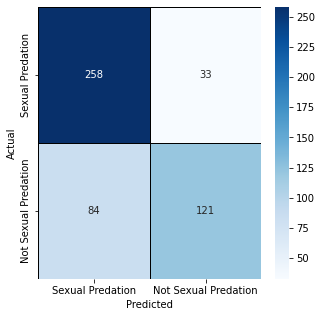

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data_test.Label, prediction_labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", 
            linecolor = 'black', 
            linewidth = 1, 
            annot = True, 
            fmt='', 
            xticklabels = ['Sexual Predation','Not Sexual Predation'], 
            yticklabels = ['Sexual Predation','Not Sexual Predation'])
plt.xlabel("Predicted")
plt.ylabel("Actual")